In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [7]:
df = np.load("Data/4.np")
print(df)

[[[ 0.00241223  0.0011588  -0.00137351]
  [ 0.00145174  0.00065382 -0.00076341]
  [ 0.00519325  0.00315593 -0.00166335]
  ...
  [ 0.00333457  0.00166071  0.00015448]
  [ 0.00138986 -0.0015858  -0.00468504]
  [-0.00300012 -0.00355646 -0.00259698]]

 [[-0.00108342 -0.00327659 -0.00396509]
  [-0.00859949 -0.0061972   0.00371526]
  [-0.00110113 -0.00077158  0.00191285]
  ...
  [ 0.00194651  0.00171701  0.00696051]
  [ 0.01625061  0.01878575  0.00357905]
  [ 0.00999151  0.0132818   0.0040159 ]]

 [[-0.00076389 -0.00113118 -0.00147295]
  [-0.00024438  0.01957563  0.03972196]
  [ 0.00481468 -0.00021434 -0.0017938 ]
  ...
  [-0.00152644 -0.00047362 -0.00109185]
  [-0.00221805 -0.00285323 -0.00421636]
  [-0.00524823  0.00010533 -0.0004616 ]]

 ...

 [[ 0.00085082  0.00431951  0.00497545]
  [ 0.00154957  0.00746835  0.01016327]
  [ 0.0016571   0.01267225  0.019301  ]
  ...
  [ 0.00121517  0.00263753  0.00183826]
  [-0.00043742 -0.00092035 -0.00367909]
  [ 0.00016793 -0.00020577 -0.00388276]]

 [

In [8]:
def distance(slice1, slice2):
    """
    Calculate the Euclidean distance between two 3D slices (40, 3) from a (75, 40, 3) array.
    """
    return np.sqrt(np.sum((slice1 - slice2)**2))

def kmeans(df, k=4, tol=0.05):
    """
    K-means clustering for 3D data.

    Parameters:
        df (numpy.ndarray): 3D numpy array with shape (75, 40, 3), each slice (40, 3) treated as a point.
        k (int): Number of clusters.
        tol (float): Tolerance for L_2 convergence check on centroids.

    Returns:
        centroids (numpy.ndarray): Array of centroids, one for each cluster.
        clusters (numpy.ndarray): Cluster assignment for each point.
        rec_error (float): Reconstruction error on final iteration.
    """    
    # Initialize reconstruction error for 1st iteration
    prev_rec_error = np.inf
    
    # Random centroids from data
    clocs = np.random.choice(df.shape[0], size=k, replace=False)
    centroids = df[clocs, :, :].copy()
    
    # Initialize objects for points-cluster distances and cluster assignments.
    dists = np.zeros((k, df.shape[0]))
    clusters = np.array([-1] * df.shape[0])
    
    # Index and convergence trackers
    ii = 0
    Done = False
    while not Done:
        # Update classifications
        for ji in range(k):
            for pi in range(df.shape[0]):
                dists[ji, pi] = distance(df[pi, :, :], centroids[ji, :, :])
        
        clusters = dists.argmin(axis=0)
        
        # Update centroids
        for ji in range(k):
            if np.sum(clusters == ji) > 0:
                centroids[ji, :, :] = np.mean(df[clusters == ji], axis=0)
            else:
                # Reinitialize centroid if no points are assigned to prevent empty clusters
                centroids[ji, :, :] = df[np.random.choice(df.shape[0], size=1), :, :]

        # Calculate Reconstruction Error    
        rec_error = np.sum(np.min(dists, axis=0)**2) / df.shape[0]
        
        # Convergence check
        change_in_error = np.abs(prev_rec_error - rec_error)
        if change_in_error < tol:
            print(f'Done at iteration {ii} with change of {change_in_error}')
            Done = True
        elif ii == 50:
            print('No convergence in 50 steps')
            Done = True
        
        prev_rec_error = rec_error
        ii += 1
    
    return centroids, clusters, rec_error

Done at iteration 1 with change of 0.0009665983565617308
Final mean error: 0.0017638577462805026
[[[ 0.00241223  0.0011588  -0.00137351]
  [ 0.00145174  0.00065382 -0.00076341]
  [ 0.00519325  0.00315593 -0.00166335]
  ...
  [ 0.00333457  0.00166071  0.00015448]
  [ 0.00138986 -0.0015858  -0.00468504]
  [-0.00300012 -0.00355646 -0.00259698]]

 [[-0.00108342 -0.00327659 -0.00396509]
  [-0.00859949 -0.0061972   0.00371526]
  [-0.00110113 -0.00077158  0.00191285]
  ...
  [ 0.00194651  0.00171701  0.00696051]
  [ 0.01625061  0.01878575  0.00357905]
  [ 0.00999151  0.0132818   0.0040159 ]]

 [[-0.00076389 -0.00113118 -0.00147295]
  [-0.00024438  0.01957563  0.03972196]
  [ 0.00481468 -0.00021434 -0.0017938 ]
  ...
  [-0.00152644 -0.00047362 -0.00109185]
  [-0.00221805 -0.00285323 -0.00421636]
  [-0.00524823  0.00010533 -0.0004616 ]]

 ...

 [[ 0.00085082  0.00431951  0.00497545]
  [ 0.00154957  0.00746835  0.01016327]
  [ 0.0016571   0.01267225  0.019301  ]
  ...
  [ 0.00121517  0.00263753 

ValueError: 'c' argument has 75 elements, which is inconsistent with 'x' and 'y' with size 9000.

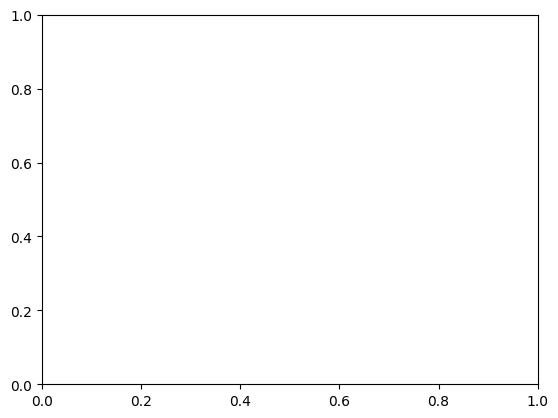

In [30]:
centroids, clusters, meanerror=kmeans(df, k=4)
print('Final mean error:', meanerror)
print(df[0:75])
plt.scatter(df[0:75], df[0:75],c=clusters)